## Kaggle Competition for Google Quickdraw https://www.kaggle.com/c/quickdraw-doodle-recognition

"Quick, Draw!" was released as an experimental game to educate the public in a playful way about how AI works. The game prompts users to draw an image depicting a certain category, such as ”banana,” “table,” etc. The game generated more than 1B drawings, of which a subset was publicly released as the basis for this competition’s training set. That subset contains 50M drawings encompassing 340 label categories.

Sounds fun, right? Here's the challenge: since the training data comes from the game itself, drawings can be incomplete or may not match the label. You’ll need to build a recognizer that can effectively learn from this noisy data and perform well on a manually-labeled test set from a different distribution.

Your task is to build a better classifier for the existing Quick, Draw! dataset. By advancing models on this dataset, Kagglers can improve pattern recognition solutions more broadly. This will have an immediate impact on handwriting recognition and its robust applications in areas including OCR (Optical Character Recognition), ASR (Automatic Speech Recognition) & NLP (Natural Language Processing).

In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import ast
import os.path

Here we import the libraries we need. We'll learn about what each does during the course.

In [4]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [5]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

`PATH` is the path to your data - if you use the recommended setup approaches from the lesson, you won't need to change this. `sz` is the size that the images will be resized to in order to ensure that the training runs quickly. We'll be talking about this parameter a lot during the course. Leave it at `224` for now.

In [6]:
PATH = "/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/"
sz=224

It's important that you have a working NVidia GPU set up. The programming framework used to behind the scenes to work with NVidia GPUs is called CUDA. Therefore, you need to ensure the following line returns `True` before you proceed. If you have problems with this, please check the FAQ and ask for help on [the forums](http://forums.fast.ai).

In [7]:
torch.cuda.is_available()

True

In addition, NVidia provides special accelerated functions for deep learning in a package called CuDNN. Although not strictly necessary, it will improve training performance significantly, and is included by default in all supported fastai configurations. Therefore, if the following does not return `True`, you may want to look into why.

In [8]:
torch.backends.cudnn.enabled

True

In [9]:
# os.makedirs('data/dogscats/models', exist_ok=True)

# !ln -s /datasets/fast.ai/dogscats/train {PATH}
# !ln -s /datasets/fast.ai/dogscats/test {PATH}
# !ln -s /datasets/fast.ai/dogscats/valid {PATH}

# os.makedirs('/cache/tmp', exist_ok=True)
# !ln -fs /cache/tmp {PATH}

In [10]:
# os.makedirs('/cache/tmp', exist_ok=True)
# !ln -fs /cache/tmp {PATH}

## First look at Data 

First Need to look at csv files 

In [11]:
os.listdir(PATH)

['all_simplifiedCSVImages',
 'sample_submission.csv',
 'simplifiedCSVImages',
 'test_raw.csv',
 'test_simplified.csv',
 'train_raw.zip',
 'train_simplified',
 'train_simplified.zip']

In [12]:
os.listdir(f'{PATH}train_simplified')

['airplane.csv',
 'alarm clock.csv',
 'ambulance.csv',
 'angel.csv',
 'animal migration.csv',
 'ant.csv',
 'anvil.csv',
 'apple.csv',
 'arm.csv',
 'asparagus.csv',
 'axe.csv',
 'backpack.csv',
 'banana.csv',
 'bandage.csv',
 'barn.csv',
 'baseball bat.csv',
 'baseball.csv',
 'basket.csv',
 'basketball.csv',
 'bat.csv',
 'bathtub.csv',
 'beach.csv',
 'bear.csv',
 'beard.csv',
 'bed.csv',
 'bee.csv',
 'belt.csv',
 'bench.csv',
 'bicycle.csv',
 'binoculars.csv',
 'bird.csv',
 'birthday cake.csv',
 'blackberry.csv',
 'blueberry.csv',
 'book.csv',
 'boomerang.csv',
 'lobster.csv',
 'lollipop.csv',
 'mailbox.csv',
 'map.csv',
 'marker.csv',
 'matches.csv',
 'megaphone.csv',
 'mermaid.csv',
 'microphone.csv',
 'microwave.csv',
 'monkey.csv',
 'moon.csv',
 'mosquito.csv',
 'motorbike.csv',
 'mountain.csv',
 'mouse.csv',
 'moustache.csv',
 'mouth.csv',
 'mug.csv',
 'mushroom.csv',
 'nail.csv',
 'necklace.csv',
 'diamond.csv',
 'dishwasher.csv',
 'diving board.csv',
 'dog.csv',
 'dolphin.csv',
 

In [13]:
data = pd.read_csv(f'{PATH}train_simplified/baseball bat.csv',
                   index_col='key_id')

In [14]:
data

,countrycode,drawing,recognized,timestamp,word
key_id,,,,,
4700595321569280,US,"[[[8, 4, 0, 0, 3, 12, 33, 40, 50, 52, 45, 33, ...",True,2017-03-05 17:01:41.446350,baseball bat
6070243518578688,US,"[[[24, 26, 22, 0, 3, 86, 90, 89, 83, 72, 55, 5...",True,2017-01-23 00:49:17.555880,baseball bat
5153967858253824,US,"[[[21, 11, 11, 27, 41, 61, 64, 60, 49, 44, 45,...",True,2017-03-27 21:54:13.360840,baseball bat
5446689877917696,BA,"[[[8, 15, 14, 9, 15, 24, 33, 28, 29, 37, 41, 4...",True,2017-03-27 15:07:03.845840,baseball bat
6234670515617792,US,"[[[114, 102, 77, 43, 13, 3, 0, 0, 11, 51, 69, ...",True,2017-03-17 15:16:20.500230,baseball bat
6720419287531520,US,"[[[210, 194, 189, 219, 234, 251, 255, 255, 250...",True,2017-03-02 14:01:43.045760,baseball bat
5812630117679104,GB,"[[[41, 23, 13, 3, 0, 5, 14, 51, 64, 67, 109, 1...",True,2017-03-16 15:04:31.161970,baseball bat
5321378892873728,US,"[[[18, 75, 125, 143, 174, 194, 214, 215, 209, ...",True,2017-01-26 19:20:27.269540,baseball bat
5849130985324544,BR,"[[[37, 34, 34, 3, 0, 4, 15, 28, 47, 54, 62, 66...",True,2017-01-31 17:22:06.720720,baseball bat


# Fixing Labels 

In [15]:
data['word'] = data['word'].replace(' ', '_', regex=True)
data

,countrycode,drawing,recognized,timestamp,word
key_id,,,,,
4700595321569280,US,"[[[8, 4, 0, 0, 3, 12, 33, 40, 50, 52, 45, 33, ...",True,2017-03-05 17:01:41.446350,baseball_bat
6070243518578688,US,"[[[24, 26, 22, 0, 3, 86, 90, 89, 83, 72, 55, 5...",True,2017-01-23 00:49:17.555880,baseball_bat
5153967858253824,US,"[[[21, 11, 11, 27, 41, 61, 64, 60, 49, 44, 45,...",True,2017-03-27 21:54:13.360840,baseball_bat
5446689877917696,BA,"[[[8, 15, 14, 9, 15, 24, 33, 28, 29, 37, 41, 4...",True,2017-03-27 15:07:03.845840,baseball_bat
6234670515617792,US,"[[[114, 102, 77, 43, 13, 3, 0, 0, 11, 51, 69, ...",True,2017-03-17 15:16:20.500230,baseball_bat
6720419287531520,US,"[[[210, 194, 189, 219, 234, 251, 255, 255, 250...",True,2017-03-02 14:01:43.045760,baseball_bat
5812630117679104,GB,"[[[41, 23, 13, 3, 0, 5, 14, 51, 64, 67, 109, 1...",True,2017-03-16 15:04:31.161970,baseball_bat
5321378892873728,US,"[[[18, 75, 125, 143, 174, 194, 214, 215, 209, ...",True,2017-01-26 19:20:27.269540,baseball_bat
5849130985324544,BR,"[[[37, 34, 34, 3, 0, 4, 15, 28, 47, 54, 62, 66...",True,2017-01-31 17:22:06.720720,baseball_bat


In [16]:
data['drawing'] = data['drawing'].apply(ast.literal_eval)

In [17]:
data.head()

,countrycode,drawing,recognized,timestamp,word
key_id,,,,,
4700595321569280,US,"[[[8, 4, 0, 0, 3, 12, 33, 40, 50, 52, 45, 33, ...",True,2017-03-05 17:01:41.446350,baseball_bat
6070243518578688,US,"[[[24, 26, 22, 0, 3, 86, 90, 89, 83, 72, 55, 5...",True,2017-01-23 00:49:17.555880,baseball_bat
5153967858253824,US,"[[[21, 11, 11, 27, 41, 61, 64, 60, 49, 44, 45,...",True,2017-03-27 21:54:13.360840,baseball_bat
5446689877917696,BA,"[[[8, 15, 14, 9, 15, 24, 33, 28, 29, 37, 41, 4...",True,2017-03-27 15:07:03.845840,baseball_bat
6234670515617792,US,"[[[114, 102, 77, 43, 13, 3, 0, 0, 11, 51, 69, ...",True,2017-03-17 15:16:20.500230,baseball_bat


In [18]:
classFolder = f'{PATH}simplifiedCSVImages/' + data.iloc[0]['word'] + "/"

In [19]:
classFolder

'/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/baseball_bat/'

In [20]:
if not os.path.exists(classFolder):
    os.makedirs(classFolder)

In [21]:
print(data.iloc[0]['drawing'][0])

[[8, 4, 0, 0, 3, 12, 33, 40, 50, 52, 45, 33, 7], [210, 215, 227, 243, 249, 253, 255, 253, 245, 237, 226, 219, 212]]


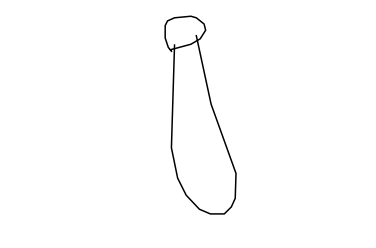

In [22]:
for x , y in data.iloc[0]['drawing']:
    #plt.plot(x, y, marker='.')
    plt.plot(x, y, 'k')
    plt.axis('off')
    plt.axis('equal')


Performing operatoin on all csv files in training folder 

In [23]:
for csv in os.listdir(f'{PATH}train_simplified'):
    csvPath = os.path.join(f'{PATH}train_simplified',csv)
    print( f"csvPath: {csvPath}" )
    data = pd.read_csv(csvPath,index_col='key_id',nrows=100)
    data['word'] = data['word'].replace(' ', '_', regex=True)
    classFolder = f'{PATH}simplifiedCSVImages/' + data.iloc[0]['word'] + "/"
    
    
    
    print(classFolder)
    if not os.path.exists(classFolder):
        os.makedirs(classFolder)
        data['drawing'] = data['drawing'].apply(ast.literal_eval)
        for index, row in data.iterrows():
            fileName = classFolder +  str(index) + ".png"
            #print(fileName)
            #print("ImageID " + str(index) )
            fig = plt.figure()
            if os.path.isfile(fileName)== False:
                for strokeX,stokeY in row['drawing']:
                    #print(stroke)
                    plt.plot(strokeX, stokeY, 'k')
                    plt.axis('off')
                    plt.axis('equal')
                    #plt.show()
                fig.savefig(fileName)
                #fig.savefig('./data/test0.png')
            plt.close(fig)
    
    
    
    

csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/airplane.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/airplane/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/alarm clock.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/alarm_clock/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/ambulance.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/ambulance/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/angel.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/angel/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/animal migration.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/animal_migration/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/ant.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/ant/
cs

csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/mouse.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/mouse/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/moustache.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/moustache/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/mouth.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/mouth/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/mug.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/mug/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/mushroom.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/mushroom/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/nail.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/nail/
csvPath: /media/dlrig/0319BAEA1F60F62B

csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/streetlight.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/streetlight/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/string bean.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/string_bean/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/submarine.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/submarine/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/suitcase.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/suitcase/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/sun.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/sun/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/swan.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/swan/
csvPath: /medi

csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/broom.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/broom/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/bucket.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/bucket/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/bulldozer.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/bulldozer/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/bus.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/bus/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/bush.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/bush/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/butterfly.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/butterfly/
csvPath: /media/dlrig/0319BAEA1F60

csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/toothpaste.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/toothpaste/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/tornado.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/tornado/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/tractor.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/tractor/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/traffic light.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/traffic_light/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/train.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/train/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/tree.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/tree/
csvPath: /medi

csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/canoe.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/canoe/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/car.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/car/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/carrot.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/carrot/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/castle.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/castle/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/cat.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/cat/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/ceiling fan.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/ceiling_fan/
csvPath: /media/dlrig/0319BAEA1F60F62B

csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/umbrella.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/umbrella/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/underwear.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/underwear/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/van.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/van/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/vase.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/vase/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/violin.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/violin/
csvPath: /media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/train_simplified/washing machine.csv
/media/dlrig/0319BAEA1F60F62B1/Mayank/quickdraw/simplifiedCSVImages/washing_machine/
csvPath: /media/

# Divide Model between training and validation set 

In [52]:
from os import listdir

In [53]:
from helpers import *

In [60]:
allDirs=[]
PATH2 = 'data/simplifiedCSVImages/'
for idx,iDir in enumerate(listdir(PATH2)):
    joinedEntry = os.path.join(PATH2,iDir)
    if os.path.isdir(joinedEntry):
        #print(joinedEntry)
        allDirs.append(iDir)

In [55]:
print(allDirs)

['see_saw', 'dragon', 'snorkel', 'cake', 'apple', 'postcard', 'peas', 'baseball_bat', 'cat', 'leaf', 'pants', 'basketball', 'microwave', 'goatee', 'toothbrush', 'tiger', 'bottlecap', 'power_outlet', 'bus', 'backpack', 'circle', 'purse', 'stethoscope', 'binoculars', 'broccoli', 'cookie', 'oven', 'screwdriver', 'mountain', 'animal_migration', 'scorpion', 'drums', 'elbow', 'frog', 'popsicle', 'cactus', 'picture_frame', 'grass', 'zebra', 'crocodile', 'snail', 'dishwasher', 'face', 'keyboard', 'mouse', 'saw', 'campfire', 'carrot', 'school_bus', 'television', 'line', 'smiley_face', 'flying_saucer', 'pizza', 'laptop', 'strawberry', 'clarinet', 'hand', 'pickup_truck', 'boomerang', 'tree', 'pig', 'hockey_stick', 'sailboat', 'tent', 'flip_flops', 'angel', 'parrot', 'teddy-bear', 'garden', 'envelope', 'whale', 'spoon', 'duck', 'skateboard', 'raccoon', 'river', 'hot_air_balloon', 'lipstick', 'The_Eiffel_Tower', 'rainbow', 'cow', 'bird', 'camera', 'bear', 'mosquito', 'eyeglasses', 'bed', 'violin', 

In [56]:
dest_dir=PATH2
print(dest_dir)
search_terms=allDirs
valid_pct = 30
prepare_training_data_directories(dest_dir)
redistribute_images(dest_dir,search_terms,valid_pct)

data/simplifiedCSVImages/
['see_saw', 'dragon', 'snorkel', 'cake', 'apple', 'postcard', 'peas', 'baseball_bat', 'cat', 'leaf', 'pants', 'basketball', 'microwave', 'goatee', 'toothbrush', 'tiger', 'bottlecap', 'power_outlet', 'bus', 'backpack', 'circle', 'purse', 'stethoscope', 'binoculars', 'broccoli', 'cookie', 'oven', 'screwdriver', 'mountain', 'animal_migration', 'scorpion', 'drums', 'elbow', 'frog', 'popsicle', 'cactus', 'picture_frame', 'grass', 'zebra', 'crocodile', 'snail', 'dishwasher', 'face', 'keyboard', 'mouse', 'saw', 'campfire', 'carrot', 'school_bus', 'television', 'line', 'smiley_face', 'flying_saucer', 'pizza', 'laptop', 'strawberry', 'clarinet', 'hand', 'pickup_truck', 'boomerang', 'tree', 'pig', 'hockey_stick', 'sailboat', 'tent', 'flip_flops', 'angel', 'parrot', 'teddy-bear', 'garden', 'envelope', 'whale', 'spoon', 'duck', 'skateboard', 'raccoon', 'river', 'hot_air_balloon', 'lipstick', 'The_Eiffel_Tower', 'rainbow', 'cow', 'bird', 'camera', 'bear', 'mosquito', 'eyeg

moving data/simplifiedCSVImages/moustache to data/simplifiedCSVImages/train/moustache
moving data/simplifiedCSVImages/leg to data/simplifiedCSVImages/train/leg
moving data/simplifiedCSVImages/paintbrush to data/simplifiedCSVImages/train/paintbrush
moving data/simplifiedCSVImages/moon to data/simplifiedCSVImages/train/moon
moving data/simplifiedCSVImages/hat to data/simplifiedCSVImages/train/hat
moving data/simplifiedCSVImages/steak to data/simplifiedCSVImages/train/steak
moving data/simplifiedCSVImages/stove to data/simplifiedCSVImages/train/stove
moving data/simplifiedCSVImages/washing_machine to data/simplifiedCSVImages/train/washing_machine
moving data/simplifiedCSVImages/sandwich to data/simplifiedCSVImages/train/sandwich
moving data/simplifiedCSVImages/hammer to data/simplifiedCSVImages/train/hammer
moving data/simplifiedCSVImages/ice_cream to data/simplifiedCSVImages/train/ice_cream
moving data/simplifiedCSVImages/tornado to data/simplifiedCSVImages/train/tornado
moving data/simp

In [61]:
os.listdir(f'{PATH2}valid')

['see_saw',
 'dragon',
 'snorkel',
 'cake',
 'apple',
 'postcard',
 'peas',
 'baseball_bat',
 'cat',
 'leaf',
 'pants',
 'basketball',
 'microwave',
 'goatee',
 'toothbrush',
 'tiger',
 'bottlecap',
 'power_outlet',
 'bus',
 'backpack',
 'circle',
 'purse',
 'stethoscope',
 'binoculars',
 'broccoli',
 'cookie',
 'oven',
 'screwdriver',
 'mountain',
 'animal_migration',
 'scorpion',
 'drums',
 'elbow',
 'frog',
 'popsicle',
 'cactus',
 'picture_frame',
 'grass',
 'zebra',
 'crocodile',
 'snail',
 'dishwasher',
 'face',
 'keyboard',
 'mouse',
 'saw',
 'campfire',
 'carrot',
 'school_bus',
 'television',
 'line',
 'smiley_face',
 'flying_saucer',
 'pizza',
 'laptop',
 'strawberry',
 'clarinet',
 'hand',
 'pickup_truck',
 'boomerang',
 'tree',
 'pig',
 'hockey_stick',
 'sailboat',
 'tent',
 'flip_flops',
 'angel',
 'parrot',
 'teddy-bear',
 'garden',
 'envelope',
 'whale',
 'spoon',
 'duck',
 'skateboard',
 'raccoon',
 'river',
 'hot_air_balloon',
 'lipstick',
 'The_Eiffel_Tower',
 'rainbo

In [62]:
files = os.listdir(f'{PATH2}valid/wheel')[:5]
files

['4639414590373888.png',
 '6196334866464768.png',
 '5412547203170304.png',
 '6688943619702784.png',
 '6450852728406016.png']

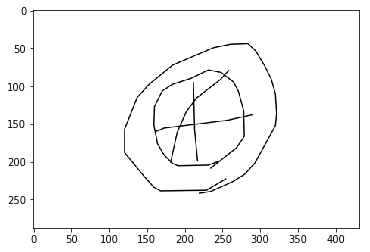

In [63]:
img = plt.imread(f'{PATH2}valid/wheel/{files[1]}')
plt.imshow(img);

## Our first model: quick start

We're going to use a <b>pre-trained</b> model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision. We'll be learning all about CNNs during this course.

We will be using the <b>resnet34</b> model. resnet34 is a version of the model that won the 2015 ImageNet competition. Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks). We'll be studying them in depth later, but for now we'll focus on using them effectively.

Here's how to train and evalulate a *dogs vs cats* model in 3 lines of code, and under 20 seconds:

In [64]:
# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

How good is this model? Well, as we mentioned, prior to this competition, the state of the art was 80% accuracy. But the competition resulted in a huge jump to 98.9% accuracy, with the author of a popular deep learning library winning the competition. Extraordinarily, less than 4 years later, we can now beat that result in seconds! Even last year in this same course, our initial model had 98.3% accuracy, which is nearly double the error we're getting just a year later, and that took around 10 minutes to compute.

The *learning rate* determines how quickly or how slowly you want to update the *weights* (or *parameters*). Learning rate is one of the most difficult parameters to set, because it significantly affects model performance.

The method `learn.lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.

We first create a new learner, since we want to know how to set the learning rate for a new (untrained) model.

In [67]:
lrf=learn.lr_find()

 90%|█████████ | 335/372 [00:38<00:03,  9.42it/s, loss=9.93]

Our `learn` object contains an attribute `sched` that contains our learning rate scheduler, and has some convenient plotting functionality including this one:

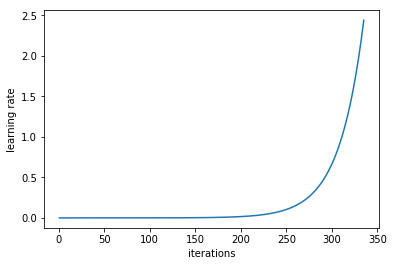

In [68]:
learn.sched.plot_lr()

Note that in the previous plot *iteration* is one iteration (or *minibatch*) of SGD. In one epoch there are 
(num_train_samples/batch_size) iterations of SGD.

We can see the plot of loss versus learning rate to see where our loss stops decreasing:

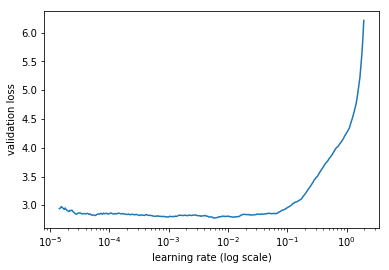

In [69]:
learn.sched.plot()

The loss is still clearly improving at lr=10-1 (0.1), so that's what we use. Note that the optimal learning rate can change as we train the model, so you may want to re-run this function from time to time.

In [71]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH2, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data)
learn.fit(0.1, 4)

epoch      trn_loss   val_loss   accuracy                    
    0      3.563283   2.986244   0.337745  
    1      3.096435   2.691513   0.390686                    
    2      2.921069   2.56175    0.414902                    
    3      2.756599   2.512352   0.418824                    


[array([2.51235]), 0.41882352943513906]

In [72]:
learn.fit(0.01, 4)

epoch      trn_loss   val_loss   accuracy                    
    0      2.403721   2.362012   0.458333  
    1      2.345723   2.330523   0.461863                    
    2      2.267392   2.314153   0.466373                    
    3      2.305572   2.300454   0.471961                    


[array([2.30045]), 0.4719607843137255]

## Improving our model

### Data augmentation

If you try training for more epochs, you'll notice that we start to *overfit*, which means that our model is learning to recognize the specific images in the training set, rather than generalizing such that we also get good results on the validation set. One way to fix this is to effectively create more data, through *data augmentation*. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

We can do this by passing `aug_tfms` (*augmentation transforms*) to `tfms_from_model`, with a list of functions to apply that randomly change the image however we wish. For photos that are largely taken from the side (e.g. most photos of dogs and cats, as opposed to photos taken from the top down, such as satellite imagery) we can use the pre-defined list of functions `transforms_side_on`. We can also specify random zooming of images up to specified scale by adding the `max_zoom` parameter.

In [75]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [76]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH2, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [77]:
ims = np.stack([get_augs() for i in range(6)])

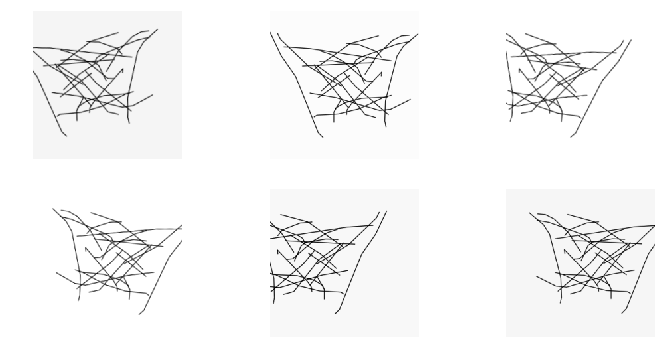

In [78]:
plots(ims, rows=2)

Let's create a new `data` object that includes this augmentation in the transforms.

In [79]:
data = ImageClassifierData.from_paths(PATH2, tfms=tfms)
learn = ConvLearner.pretrained(arch, data)

In [80]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                    
    0      4.394699   3.75612    0.258039  


[array([3.75612]), 0.2580392157096489]

In [81]:
learn.precompute=False

By default when we create a learner, it sets all but the last layer to *frozen*. That means that it's still only updating the weights in the last layer when we call `fit`.

In [82]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      3.795305   3.38828    0.312059  
    1      3.528304   3.128155   0.346078                    
    2      3.368074   2.95168    0.36951                     


[array([2.95168]), 0.36950980389819427]

### Fine-tuning and differential learning rate annealing

Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) `unfreeze()`.

In [83]:
learn.unfreeze()

Note that the other layers have *already* been trained to recognize imagenet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as *differential learning rates*, although there's no standard name for this techique in the literature that we're aware of.

In [84]:
lr=np.array([1e-3,1e-2,1e-1])

In [85]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      2.658576   2.177004   0.505686  
    1      2.393913   1.942332   0.536765                    
    2      1.833396   1.692475   0.593431                    
    3      2.111928   1.856808   0.548529                    
    4      1.81112    1.682549   0.592745                    
    5      1.405226   1.538742   0.62951                     
    6      1.188518   1.511164   0.63598                     


[array([1.51116]), 0.635980392110114]

Another trick we've used here is adding the `cycle_mult` parameter. Take a look at the following chart, and see if you can figure out what the parameter is doing:

In [87]:
#lr=np.array([1e-4,1e-3,1e-2])

In [88]:
#learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

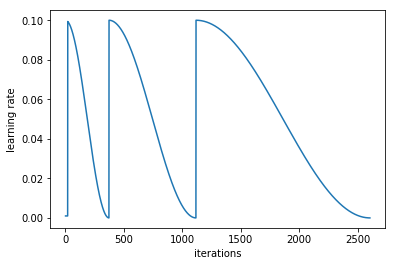

In [89]:
learn.sched.plot_lr()

Note that's what being plotted above is the learning rate of the *final layers*. The learning rates of the earlier layers are fixed at the same multiples of the final layer rates as we initially requested (i.e. the first layers have 100x smaller, and middle layers 10x smaller learning rates, since we set `lr=np.array([1e-4,1e-3,1e-2])`.

In [90]:
learn.save('224_all')

In [91]:
learn.load('224_all')

There is something else we can do with data augmentation: use it at *inference* time (also known as *test* time). Not surprisingly, this is known as *test time augmentation*, or just *TTA*.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's `TTA()` method.

In [92]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [93]:
accuracy_np(probs, y)

0.645

I generally see about a 10-20% reduction in error on this dataset when using TTA at this point, which is an amazing result for such a quick and easy technique!

## Analyzing results: looking at pictures

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (i.e. those with highest probability that are correct)
4. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
5. The most uncertain labels (i.e. those with probability closest to 0.5).

In [94]:
# This is the label for a val data
data.val_y

array([  0,   0,   0, ..., 339, 339, 339])

In [95]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['The_Eiffel_Tower',
 'The_Great_Wall_of_China',
 'The_Mona_Lisa',
 'airplane',
 'alarm_clock',
 'ambulance',
 'angel',
 'animal_migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball_bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday_cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling_fan',
 'cell_phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee_cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 '

In [96]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(10200, 340)

In [97]:
log_preds[:10]

array([[ -0.15342, -10.08473,  -9.00395, ..., -10.32875, -10.8622 , -11.28625],
       [ -1.98246,  -2.69664,  -6.71668, ...,  -4.57609,  -6.21284,  -7.9904 ],
       [ -2.69685, -10.45333, -10.3953 , ...,  -8.65974, -12.03455, -13.15351],
       ...,
       [ -0.10537,  -5.64675,  -9.16432, ...,  -6.04332,  -9.53014,  -9.81042],
       [ -0.00497, -15.53174, -17.37789, ..., -11.58023, -16.24319, -13.54634],
       [ -0.00316, -14.42501, -11.96132, ..., -13.53265, -13.49269, -15.55586]], dtype=float32)

In [108]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [109]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [110]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [111]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH2+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

Correctly classified


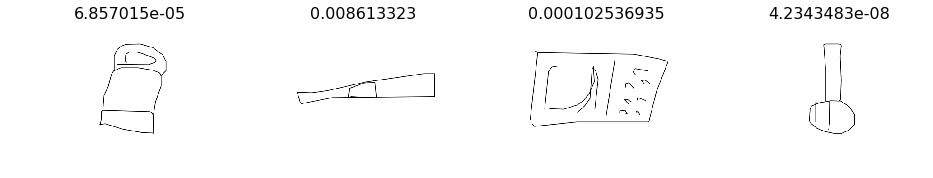

In [112]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


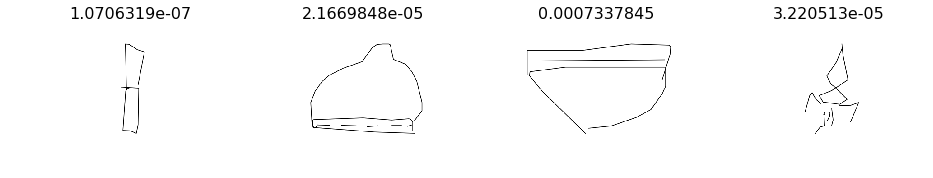

In [113]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [114]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct 


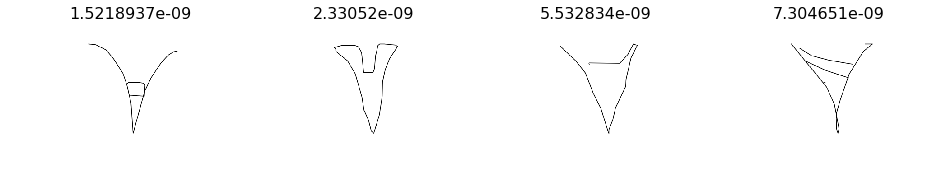

In [115]:
plot_val_with_title(most_by_correct(0, True), "Most correct ")

Most correct 


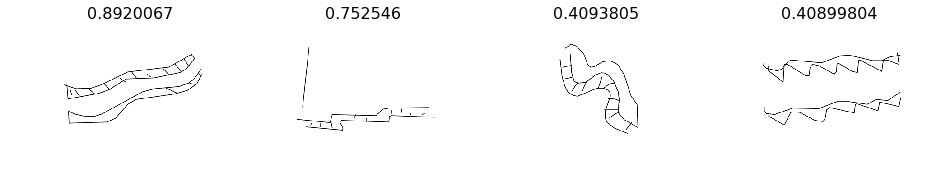

In [116]:
plot_val_with_title(most_by_correct(1, True), "Most correct ")

Most incorrect 


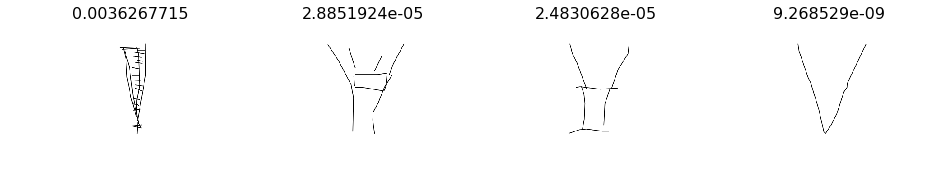

In [117]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect ")

Most incorrect 


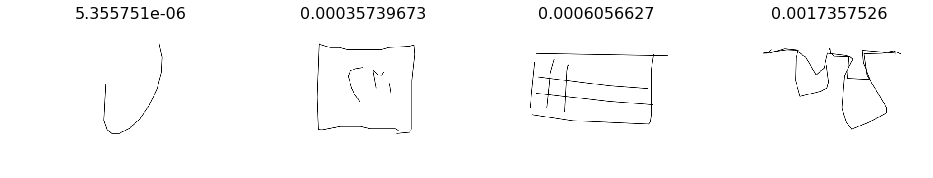

In [118]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect ")

Most uncertain predictions


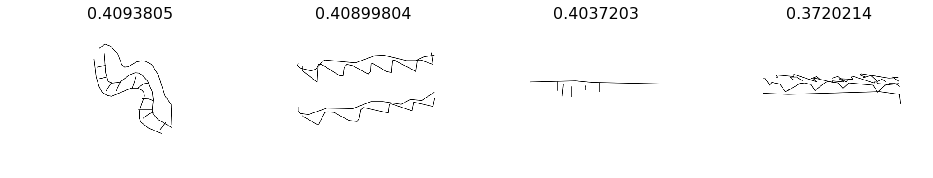

In [119]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Choosing a learning rate

Since we've got a pretty good model at this point, we might want to save it so we can load it again later without training it from scratch.

In [120]:
learn.save('224_lastlayer')

In [121]:
learn.load('224_lastlayer')

### Getting Test output 

In [128]:
trn_tfms, val_tfms = tfms_from_model(arch,sz)

im = val_tfms(open_image(f'{PATH2}valid/airplane/4554736336371712.png'))
print(im[None].shape)
print(im.shape)

learn.precompute=False # We'll pass in a raw image, not activations
preds = learn.predict_array(im[None])
# np.argmax(preds) # preds are log probabilities of classes
# For top 3 resuls 
np.argmax(preds)


(1, 3, 224, 224)
(3, 224, 224)


3

In [133]:
print(preds.argsort()[-3:][::-1])


[[147 304 181 266 107  39 109  41 231 242  35 279  18 229 153  91 232 288  77 313 177  36 273  68  55 289
  194  89 213 329 129 278 163  43 185 148 100 328 197 216  81  57  73 310  96 248 284 179 184 264 274 196
  130 223  95 142 249 237 200 157  80 215  23 217 146  12  50  14  53 219  29 125  26 106 140 309 317 160
  205 269 167  90 298 286 203 251 233  42 314 133 228  21  30 292 258 214 277 267  54  37   4 143 173 103
  250 174 152 222   2  60 224 121 102 221 128 110  47  76  27 336 162 324 291 259 290 268 272  15  49  32
  108   1 306 145 319 294 187  61  16  83  79 191  58  82 326 135 158 156 245 210 180 151 321 132 238 312
  325 204 315 186 239  34 302 164 301 330 282 261 296 234 334  88  31 104 117 285 332 154 280  75 208 254
  265 281 225  74 170 307 244   6  20 131 134  64 178   8  69 183 202 192 137 198  17  85 189  78  45 240
  114 136 262 212 165 169   5 311 295 122  98  92 105 260  10  70  84  38 300  46  99 209 199 120 287 318
  127 263  19 138 270 190  87 246 171 113 141 